In [3]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
from keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

Using TensorFlow backend.


The code below takes the data that is stored in a single directory, and separates it by train, validation, and test, and then also by class, into separate sub-directories.

In [2]:
attribute_import = pd.read_csv('list_attr_celeba.txt', delim_whitespace=True)
attractive = attribute_import['Attractive'].replace(-1, 0)

columns = ['image','group']
eval_groups = pd.read_csv('list_eval_partition.txt',
                          names=columns, delim_whitespace=True, header=-1)
eval_groups['Attractive'] = attractive.values
eval_groups.head()

NameError: name 'pd' is not defined

In [39]:
def name_folder(x):
    if (x['group'] == 0) & (x['Attractive'] == 0):
        return 'train_dir/not_attractive'
    if (x['group'] == 0) & (x['Attractive'] == 1):
        return 'train_dir/attractive'
    if (x['group'] == 1) & (x['Attractive'] == 0):
        return 'validation_dir/not_attractive'
    if (x['group'] == 1) & (x['Attractive'] == 1):
        return 'validation_dir/attractive'
    if (x['group'] == 2) & (x['Attractive'] == 0):
        return 'test_dir/not_attractive'
    if (x['group'] == 2) & (x['Attractive'] == 1):
        return 'test_dir/attractive'
    
eval_groups['name_folder'] = eval_groups.apply(lambda x: name_folder(x), axis=1)

def move_file(x):
    destination = eval_groups[eval_groups['image'] == x]['name_folder'].values[0]
    os.rename('celeba/' + x, 'base_dir/' + destination + '/' + x)
    return

[move_file(x) for x in os.listdir('celeba')]

Frequency chart for 'Attractive' vs. 'Not Attractive':

In [3]:
attractive.value_counts()

1    103833
0     98766
Name: Attractive, dtype: int64

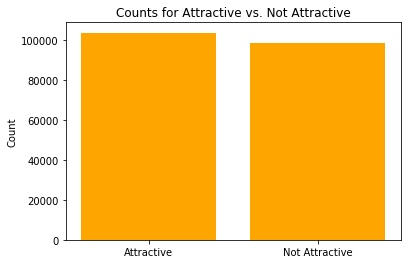

In [4]:
plt.bar(['Attractive','Not Attractive'],
        attractive.value_counts(),
       color='orange')
plt.title("Counts for Attractive vs. Not Attractive")
plt.ylabel("Count")
plt.show()

In [29]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(218, 178, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3,3), kernel_regularizer=regularizers.l2(.001), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3,3), kernel_regularizer=regularizers.l2(.001), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3,3), kernel_regularizer=regularizers.l2(.001), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(.3))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

callbacks_list = [callbacks.EarlyStopping(monitor='val_acc',
                                           patience=5,
                                           ),
                 callbacks.ModelCheckpoint(filepath='best_model.h5',
                                            monitor='val_loss',
                                            save_best_only=True)]

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [30]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 216, 176, 32)      896       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 108, 88, 32)       0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 106, 86, 64)       18496     
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 53, 43, 64)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 51, 41, 64)        36928     
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 25, 20, 64)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 23, 18, 128)      

In [28]:
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory("base_dir/train_dir",
                                                    target_size=(218, 178),
                                                   batch_size=32,
                                                   class_mode='binary')

validation_generator = train_datagen.flow_from_directory("base_dir/validation_dir",
                                                    target_size=(218, 178),
                                                   batch_size=32,
                                                   class_mode='binary')


Found 162770 images belonging to 2 classes.
Found 19867 images belonging to 2 classes.


In [31]:
for data_batch, labels_batch in train_generator:
    print("Data Batch Shape: ", data_batch.shape)
    print("Labels Batch Shape: ", labels_batch.shape)
    break

Data Batch Shape:  (32, 218, 178, 3)
Labels Batch Shape:  (32,)


In [31]:
history2 = model.fit_generator(train_generator,
                             steps_per_epoch=300, # number of mini-batches per epoch
                             epochs=200,
                             callbacks=callbacks_list,
                             validation_data=validation_generator,
                             validation_steps=50)

Epoch 1/200
300/300 [==============================] - 149s 498ms/step - loss: 0.7202 - acc: 0.5705 - val_loss: 0.6335 - val_acc: 0.6725
Epoch 2/200
300/300 [==============================] - 133s 444ms/step - loss: 0.6139 - acc: 0.6753 - val_loss: 0.6057 - val_acc: 0.6775
Epoch 3/200
300/300 [==============================] - 140s 466ms/step - loss: 0.5655 - acc: 0.7202 - val_loss: 0.5487 - val_acc: 0.7256
Epoch 4/200
300/300 [==============================] - 131s 438ms/step - loss: 0.5204 - acc: 0.7539 - val_loss: 0.5245 - val_acc: 0.7500
Epoch 5/200
300/300 [==============================] - 137s 458ms/step - loss: 0.5057 - acc: 0.7583 - val_loss: 0.5024 - val_acc: 0.7644
Epoch 6/200
300/300 [==============================] - 138s 459ms/step - loss: 0.4972 - acc: 0.7642 - val_loss: 0.4940 - val_acc: 0.7806
Epoch 7/200
300/300 [==============================] - 134s 445ms/step - loss: 0.4885 - acc: 0.7747 - val_loss: 0.4866 - val_acc: 0.7681
Epoch 8/200
300/300 [====================

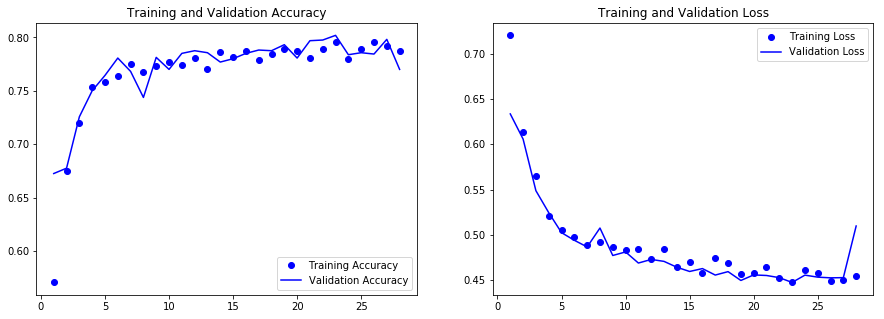

In [37]:
acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title("Training and Validation Loss")
plt.legend()

In [7]:
model.save('model_30_epochs.h5',True,False)

In [5]:
preds_attractive = np.array([])
directory_attractive = 'base_dir/test_dir/attractive/'
for i in np.arange(len(os.listdir(directory_attractive))):
    x = os.listdir(directory_attractive)[i]
    img = image.load_img(directory_attractive+x, target_size=(218, 178))
    x = image.img_to_array(img) / 255.0
    x = np.expand_dims(x, axis=0) # add dimension to be able to fit into model
    pred = model.predict(x)
    preds_attractive = np.append(preds_attractive, pred)

In [37]:
print(preds_attractive[np.argmin(preds_attractive)])
os.listdir(directory_attractive)[np.argmin(preds_attractive)]

0.003945245873183012


'187028.jpg'

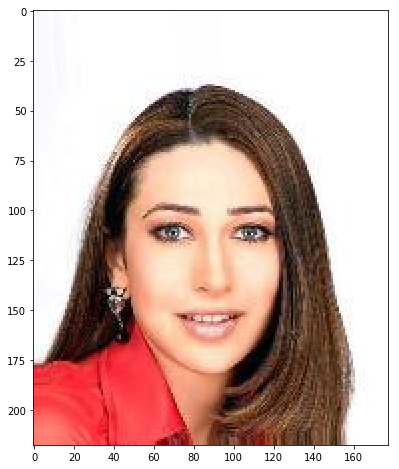

In [7]:
image_bgr = cv2.imread(directory_attractive+os.listdir(directory_attractive)[np.argmin(preds_attractive)], cv2.IMREAD_COLOR)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8,8))
plt.imshow(image_rgb)

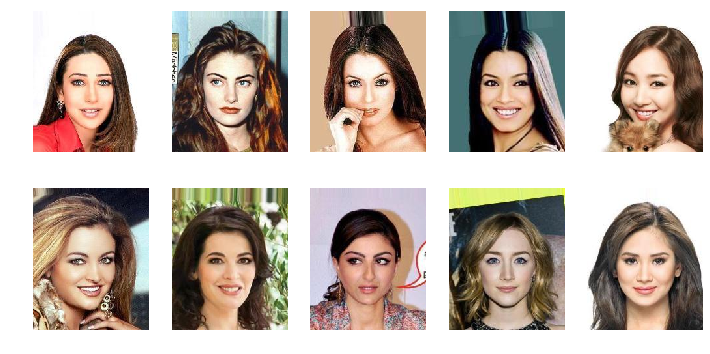

In [38]:
plt.figure(figsize=(12,6))
for i in np.array([0,1,2,3,4,5,6,7,8,9]):
    image_bgr = cv2.imread(directory_attractive+os.listdir(directory_attractive)[np.argsort(preds_attractive)[i]], cv2.IMREAD_COLOR)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    plt.subplot(2,5,i+1)
    plt.imshow(image_rgb)
    plt.axis("off")

array([8870, 8058, 9822, 5769, 6047])

In [40]:
for i in np.arange(9):
    print(os.listdir(directory_attractive)[np.argsort(preds_attractive)[i]])

187028.jpg
200549.jpg
196706.jpg
195915.jpg
200742.jpg
199357.jpg
187538.jpg
194058.jpg
193541.jpg


In [ ]:
preds_not_att = np.array([])
directory_not_att = 'base_dir/test_dir/not_attractive/'
for i in np.arange(len(os.listdir(directory_not_att))):
    x = os.listdir(directory_not_att)[i]
    img = image.load_img(directory_not_att+x, target_size=(218, 178))
    x = image.img_to_array(img) / 255.0
    x = np.expand_dims(x, axis=0) # add dimension to be able to fit into model
    pred = model.predict(x)
    preds_not_att = np.append(preds_not_att, pred)

In [10]:
print(preds_not_att[np.argmin(preds_not_att)])
os.listdir(directory_not_att)[np.argmax(preds_not_att)]

0.04286997765302658


'198262.jpg'

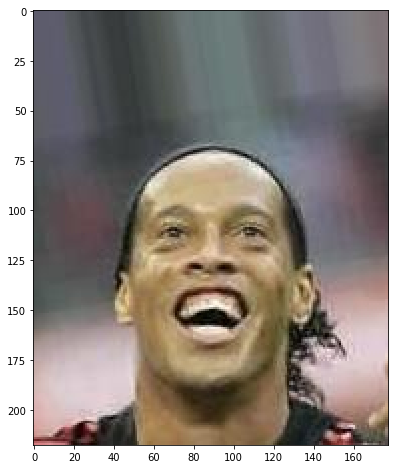

In [11]:
image_bgr = cv2.imread(directory_not_att+os.listdir(directory_not_att)[np.argmax(preds_not_att)], cv2.IMREAD_COLOR)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8,8))
plt.imshow(image_rgb)

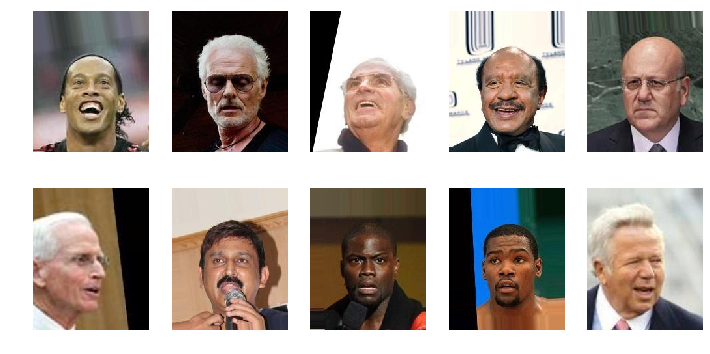

In [42]:
plt.figure(figsize=(12,6))
for i in np.array([1,2,3,4,5,6,7,8,9,10]):
    image_bgr = cv2.imread(directory_not_att+os.listdir(directory_not_att)[np.argsort(preds_not_att)[-i]], cv2.IMREAD_COLOR)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    plt.subplot(2,5,i)
    plt.imshow(image_rgb)
    plt.axis("off")

In [50]:
np.argsort(preds_not_att)[-1]

7169

In [53]:
for i in np.arange(1,12):
    print(os.listdir(directory_not_att)[np.argsort(preds_not_att)[-i]])

198262.jpg
184718.jpg
198106.jpg
193772.jpg
190654.jpg
183110.jpg
189073.jpg
186912.jpg
191835.jpg
195641.jpg
183976.jpg


In [7]:
import os
os.getcwd()

'/gpfs_home/guest320/Final Project'

In [1]:
! ls

2040 Facial Attractiveness.ipynb  images_clean_grey.npy
base_dir			  images_clean_grey-spiral.npy
best_model_2.h5			  list_attr_celeba.txt
best_model.h5			  list_eval_partition.txt
celeba				  model_30_epochs.h5
celeba.zip			  Space VAE.ipynb
images


In [ ]:
model = load_model('model_30_epochs.h5')

In [4]:
model.save('best_model.h5',True,False)

In [36]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 216, 176, 32)      896       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 108, 88, 32)       0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 106, 86, 64)       18496     
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 53, 43, 64)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 51, 41, 64)        36928     
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 25, 20, 64)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 23, 18, 128)      